<a href="https://colab.research.google.com/github/AliciaV15/Zephyr-7B-Beta_FineTuning/blob/master/ProyectoFinal.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install gdown


In [2]:
!pip install accelerate
!pip install -i https://pypi.org/simple/ bitsandbytes

Looking in indexes: https://pypi.org/simple/


In [ ]:
import torch
from transformers import pipeline

pipe = pipeline("text-generation", model="HuggingFaceH4/zephyr-7b-beta", torch_dtype=torch.bfloat16, device_map="auto")

In [ ]:
preguntas = [
    # 5 preguntas de primaria
    "¿Qué es la fotosíntesis?",
    "¿Qué es el aparato digestivo?",
    "¿Qué es la electricidad estática?",
    "Explícame cómo funciona el ciclo del agua.",
    "Explícame la teoría de la evolución.",
    # 5 preguntas de secundaria
    "¿Qué fue la Revolución Francesa?",
    "Explícame las leyes de Newton.",
    "Explícame el ciclo del carbono.",
    "Explícame la teoría atómica.",
    "¿Qué es el imperialismo?"

]

archivo_salida = "preguntas_respuestas_SIN_FT.txt"

# Abrir el archivo en modo escritura
with open(archivo_salida, 'w') as archivo:
    # Iterar sobre cada pregunta
    for pregunta in preguntas:
        # Crear el mensaje con la pregunta
        messages = [{"role": "user", "content": pregunta}]

        # Aplicar el template del tokenizer
        prompt = pipe.tokenizer.apply_chat_template(messages, tokenize=False, add_generation_prompt=True)

        # Obtener la respuesta del modelo
        outputs = pipe(prompt, max_new_tokens=500, do_sample=True, temperature=0.7, top_k=50, top_p=0.95)
        respuesta = outputs[0]["generated_text"]
        print("Pregunta: ", pregunta)
        print("Respuesta: ", respuesta)
        print()

        # Escribir la pregunta y la respuesta en el archivo
        archivo.write(f"Pregunta: {pregunta}\n")
        archivo.write(f"Respuesta: {respuesta}\n\n")

print("Preguntas y respuestas guardadas en", archivo_salida)

Pregunta:  ¿Qué es la fotosíntesis?
Respuesta:  <|user|>
¿Qué es la fotosíntesis?</s>
<|assistant|>
La fotosíntesis es un proceso natural que ocurre en las plantas, algas y cianobacterias para generar energía y materia orgánica a partir de la luz solar, el agua y el dióxido de carbono del aire. Este proceso es fundamental para la vida en la Tierra, ya que proporciona el oxígeno atmosférico y la mayoría de la biomasa que forma la base de la cadena alimentaria para los animales y los seres humanos. En resumen, la fotosíntesis es el proceso por el cual las plantas y otros organismos convertiden la energía solar en energía química que pueden usar para vivir y crecer.

Pregunta:  ¿Qué es el aparato digestivo?
Respuesta:  <|user|>
¿Qué es el aparato digestivo?</s>
<|assistant|>
El aparato digestivo es el sistema biológico encargado de procesar y romper los alimentos en nutrientes que el cuerpo pueda absorber y utilizar. Comprende varias estructuras y procesos que se desarrollan en la boca, e

##FINE-TUNING

In [3]:
!pip install accelerate trl peft datasets

In [4]:
from datasets import load_dataset

dataset_name = "alivi/QASpanish"

dataset = load_dataset(dataset_name, split="train")


In [5]:
dataset[2]

{'pregunta': '¿Qué es la fotosíntesis?',
 'respuesta': 'La fotosíntesis es el proceso por el cual las plantas, algas y algunas bacterias convierten la luz solar en energía química. Este proceso se lleva a cabo en los cloroplastos de las células vegetales, donde la clorofila absorbe la luz solar. Durante la fotosíntesis, las plantas toman dióxido de carbono del aire y agua del suelo, y utilizan la energía solar para convertir estos componentes en glucosa (un tipo de azúcar) y oxígeno. La ecuación química de la fotosíntesis es: 6CO2 + 6H2O + luz solar → C6H12O6 + 6O2. La glucosa es utilizada por la planta como fuente de energía y para crecer, mientras que el oxígeno es liberado al aire.'}

In [6]:
!huggingface-cli login


    _|    _|  _|    _|    _|_|_|    _|_|_|  _|_|_|  _|      _|    _|_|_|      _|_|_|_|    _|_|      _|_|_|  _|_|_|_|
    _|    _|  _|    _|  _|        _|          _|    _|_|    _|  _|            _|        _|    _|  _|        _|
    _|_|_|_|  _|    _|  _|  _|_|  _|  _|_|    _|    _|  _|  _|  _|  _|_|      _|_|_|    _|_|_|_|  _|        _|_|_|
    _|    _|  _|    _|  _|    _|  _|    _|    _|    _|    _|_|  _|    _|      _|        _|    _|  _|        _|
    _|    _|    _|_|      _|_|_|    _|_|_|  _|_|_|  _|      _|    _|_|_|      _|        _|    _|    _|_|_|  _|_|_|_|

    A token is already saved on your machine. Run `huggingface-cli whoami` to get more information or `huggingface-cli logout` if you want to log out.
    Setting a new token will erase the existing one.
    To login, `huggingface_hub` requires a token generated from https://huggingface.co/settings/tokens .
Enter your token (input will not be visible): 
Add token as git credential? (Y/n) n
Token is valid (permission: write)

In [7]:
!huggingface-cli whoami

alivi


In [8]:
import torch.cuda
import torch

torch.cuda.set_device(0)

from transformers import AutoTokenizer, AutoModelForCausalLM, BitsAndBytesConfig

bnb_config = BitsAndBytesConfig(load_in_4bit=True,
    bnb_4bit_quant_type="nf4",
    bnb_4bit_compute_dtype=torch.bfloat16,
    bnb_4bit_use_double_quant=False)

tokenizer = AutoTokenizer.from_pretrained("HuggingFaceH4/zephyr-7b-beta")
tokenizer.pad_token = tokenizer.eos_token

model = AutoModelForCausalLM.from_pretrained("HuggingFaceH4/zephyr-7b-beta", quantization_config=bnb_config, device_map = 'auto')

model.safetensors.index.json:   0%|          | 0.00/23.9k [00:00<?, ?B/s]

model-00001-of-00008.safetensors:   0%|          | 0.00/1.89G [00:00<?, ?B/s]

model-00002-of-00008.safetensors:   0%|          | 0.00/1.95G [00:00<?, ?B/s]

model-00003-of-00008.safetensors:   0%|          | 0.00/1.98G [00:00<?, ?B/s]

model-00004-of-00008.safetensors:   0%|          | 0.00/1.95G [00:00<?, ?B/s]

model-00005-of-00008.safetensors:   0%|          | 0.00/1.98G [00:00<?, ?B/s]

model-00006-of-00008.safetensors:   0%|          | 0.00/1.95G [00:00<?, ?B/s]

model-00007-of-00008.safetensors:   0%|          | 0.00/1.98G [00:00<?, ?B/s]

model-00008-of-00008.safetensors:   0%|          | 0.00/816M [00:00<?, ?B/s]

Loading checkpoint shards:   0%|          | 0/8 [00:00<?, ?it/s]

generation_config.json:   0%|          | 0.00/111 [00:00<?, ?B/s]

### Configuración LORA

In [9]:
from peft import PeftModel, prepare_model_for_kbit_training, get_peft_model, LoraConfig, TaskType

model.gradient_checkpointing_enable()
model = prepare_model_for_kbit_training(model)

In [10]:
peft_config = LoraConfig(
    task_type=TaskType.CAUSAL_LM,
    inference_mode=False,
    r=64,
    lora_alpha=32,
    lora_dropout=0.1
)
peft_model = get_peft_model(model, peft_config)
peft_model = peft_model.to('cuda')

In [11]:
def print_trainable_parameters(model):
    trainable_params = 0
    all_param = 0
    for _, param in model.named_parameters():
        all_param += param.numel()
        if param.requires_grad:
            trainable_params += param.numel()
    print(
        f"Parametros entrenables: {trainable_params} || Todos los parametros: {all_param} || Entrenable%: {100 * trainable_params / all_param}"
    )

print_trainable_parameters(peft_model)

Parametros entrenables: 27262976 || Todos los parametros: 3779334144 || Entrenable%: 0.7213698223345028


### Configuración del entrenamiento

In [12]:
max_seq_length = 512

from transformers import TrainingArguments, EarlyStoppingCallback
from trl import SFTTrainer
output_dir = "./results"
optim = "paged_adamw_32bit"
training_args = TrainingArguments(
    output_dir=output_dir,
    overwrite_output_dir=True,
    optim=optim,
    learning_rate=1e-4,
    logging_steps=10,
    max_steps=100,
    warmup_ratio=0.3,
    per_device_train_batch_size=8,
    gradient_accumulation_steps=4,
    gradient_checkpointing=True,
    save_total_limit = 5,
    fp16=True

)

In [13]:
def process_data(examples):
    texts = []
    for preg, resp in zip(examples["pregunta"], examples["respuesta"]):
        # Formato para un solo mensaje con prompt del sistema
        text = f"<s>[INST] <<SYS>> {preg} [/INST] {resp}</s>"
        texts.append(text)
    # Creamos un dataset con la estructura deseada
    dataset = Dataset.from_dict({"text": texts})

    return dataset

def format_function(example):
    return example['text']

In [14]:
from datasets import Dataset
dataset = process_data(dataset)

In [15]:
print(dataset)

Dataset({
    features: ['text'],
    num_rows: 99
})


### Entrenamiento del Modelo

In [16]:
from trl import SFTTrainer, SFTConfig

peft_trainer = SFTTrainer(
    model=peft_model,
    train_dataset=dataset,
    peft_config=peft_config,
    max_seq_length=max_seq_length,
    tokenizer=tokenizer,
    args=training_args,
    formatting_func=format_function)

peft_trainer.train()
peft_trainer.model.save_pretrained('fine-tuning_Zephyr-7b2')

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_deprecation.py:100: FutureWarning: Deprecated argument(s) used in '__init__': max_seq_length. Will not be supported from version '1.0.0'.

Deprecated positional argument(s) used in SFTTrainer, please use the SFTConfig to set these arguments instead.
  warnings.warn(message, FutureWarning)
/usr/local/lib/python3.10/dist-packages/transformers/training_args.py:1965: FutureWarning: `--push_to_hub_token` is deprecated and will be removed in version 5 of 🤗 Transformers. Use `--hub_token` instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/trl/trainer/sft_trainer.py:269: UserWarning: You passed a `max_seq_length` argument to the SFTTrainer, the value you passed will override the one in the `SFTConfig`.
  warnings.warn(


Map:   0%|          | 0/99 [00:00<?, ? examples/s]

/usr/local/lib/python3.10/dist-packages/trl/trainer/sft_trainer.py:397: UserWarning: You passed a tokenizer with `padding_side` not equal to `right` to the SFTTrainer. This might lead to some unexpected behaviour due to overflow issues when training a model in half-precision. You might consider adding `tokenizer.padding_side = 'right'` to your code.
  warnings.warn(
max_steps is given, it will override any value given in num_train_epochs
`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...
/usr/local/lib/python3.10/dist-packages/torch/utils/checkpoint.py:464: UserWarning: torch.utils.checkpoint: the use_reentrant parameter should be passed explicitly. In version 2.4 we will raise an exception if use_reentrant is not passed. use_reentrant=False is recommended, but if you need to preserve the current default behavior, you can pass use_reentrant=True. Refer to docs for more details on the differences between the two variants.
  warnings.warn(


Step,Training Loss
10,1.216500
20,1.026500
30,0.822000
40,0.656100
50,0.501100
60,0.374100
70,0.277900
80,0.213500
90,0.176700
100,0.159100


/usr/local/lib/python3.10/dist-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


In [ ]:
import pandas as pd
print(peft_trainer.state.log_history)

[{'loss': 1.2276, 'grad_norm': 0.9287158250808716, 'learning_rate': 2.2222222222222223e-05, 'epoch': 3.076923076923077, 'step': 10}, {'loss': 1.081, 'grad_norm': 1.0609898567199707, 'learning_rate': 4.4444444444444447e-05, 'epoch': 6.153846153846154, 'step': 20}, {'loss': 0.8909, 'grad_norm': 0.4691069722175598, 'learning_rate': 6.666666666666667e-05, 'epoch': 9.23076923076923, 'step': 30}, {'loss': 0.7459, 'grad_norm': 0.4529132843017578, 'learning_rate': 8.888888888888889e-05, 'epoch': 12.307692307692308, 'step': 40}, {'loss': 0.5886, 'grad_norm': 0.5130980014801025, 'learning_rate': 9.523809523809524e-05, 'epoch': 15.384615384615385, 'step': 50}, {'loss': 0.4238, 'grad_norm': 0.6761297583580017, 'learning_rate': 8.571428571428571e-05, 'epoch': 18.46153846153846, 'step': 60}, {'loss': 0.2922, 'grad_norm': 0.9269594550132751, 'learning_rate': 7.619047619047618e-05, 'epoch': 21.53846153846154, 'step': 70}, {'loss': 0.202, 'grad_norm': 0.6547591090202332, 'learning_rate': 6.666666666666

<Axes: xlabel='step'>

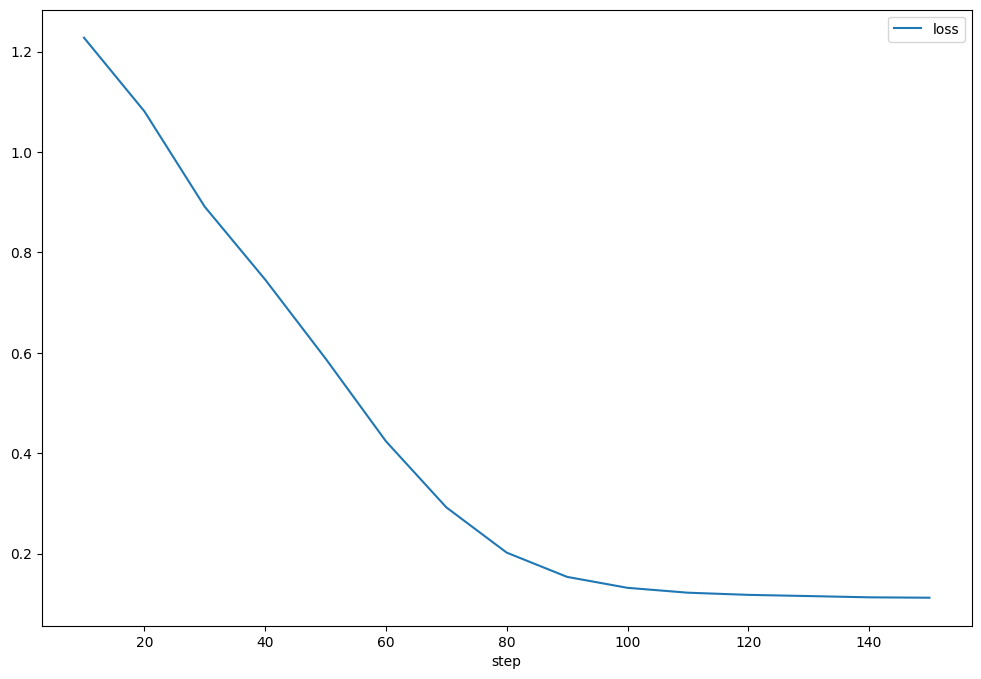

In [ ]:
df_history = pd.DataFrame(peft_trainer.state.log_history)
df_history.plot(x='step', y='loss', figsize=(12, 8))

### Inferencia

In [ ]:
preguntas = [
    # 5 preguntas de primaria
    "¿Qué es la fotosíntesis?",
    "¿Qué es el aparato digestivo?",
    "¿Qué es la electricidad estática?",
    "Explícame cómo funciona el ciclo del agua.",
    "Explícame la teoría de la evolución.",
    # 5 preguntas de secundaria
    "¿Qué fue la Revolución Francesa?",
    "Explícame las leyes de Newton.",
    "Explícame el ciclo del carbono.",
    "Explícame la teoría atómica.",
    "¿Qué es el imperialismo?"

]

In [ ]:
archivo_salida2 = "preguntas_respuestas_FT2.txt"

# Abrir el archivo en modo escritura
with open(archivo_salida2, 'w') as archivo:
    # Iterar sobre cada pregunta
    for pregunta in preguntas:

        messages = [{"role": "user", "content": pregunta}]
        tokenized_chat = tokenizer.apply_chat_template(messages, tokenize=True, add_generation_prompt=False, return_tensors="pt")
        outputs = peft_model.generate(tokenized_chat.to('cuda'), max_new_tokens=500)

        respuesta = tokenizer.decode(outputs[0])

        print("Pregunta: ", pregunta)
        print("Respuesta: ", respuesta)
        print()

        # Escribir la pregunta y la respuesta en el archivo
        archivo.write(f"Pregunta: {pregunta}\n")
        archivo.write(f"Respuesta: {respuesta}\n\n")

print("Preguntas y respuestas guardadas en", archivo_salida2)

The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
/usr/local/lib/python3.10/dist-packages/torch/utils/checkpoint.py:464: UserWarning: torch.utils.checkpoint: the use_reentrant parameter should be passed explicitly. In version 2.4 we will raise an exception if use_reentrant is not passed. use_reentrant=False is recommended, but if you need to preserve the current default behavior, you can pass use_reentrant=True. Refer to docs for more details on the differences between the two variants.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torch/utils/checkpoint.py:91: UserWarning: None of the inputs have requires_grad=True. Gradients will be None
  warnings.warn(
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your i

Pregunta:  ¿Qué es la fotosíntesis?
Respuesta:  <|user|>
¿Qué es la fotosíntesis?</s> 
<|assistant|> La fotosíntesis es el proceso por el cual las plantas, algas y algunas bacterias convierten la luz solar en energía química. Este proceso se lleva a cabo en los cloroplastos de las células vegetales, donde la clorofila absorbe la luz solar. Durante la fotosíntesis, las plantas toman dióxido de carbono del aire y agua del suelo, y utilizan la energía solar para convertir estos componentes en glucosa (un tipo de azúcar) y oxígeno. La ecuación química del proceso es: $6CO2+6H2O+luz\ rightarrow C6H12O6+6O2$. La glucosa es utilizada por la planta como fuente de energía y para crecer, mientras que el oxígeno es liberado al aire. La fotosíntesis es fundamental para la vida en la Tierra, ya que proporciona oxígeno al aire y es la base de la cadena alimentaria.</s>



The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Pregunta:  ¿Qué es el aparato digestivo?
Respuesta:  <|user|>
¿Qué es el aparato digestivo?</s> 
<|assistant|> El aparato digestivo es una de las sistemas del cuerpo humano que está encargado de descomponer los alimentos, absorber los nutrientes y eliminar los desechos. Este proceso comienza en la boca, donde los alimentos entran a la boca de estómago, que mezcla y rompe los alimentos con jugos digestivos. Luego, el quimo estomacal viaja al intestino delgado, donde la mayoría de los nutrientes se absorben a través de las paredes intestinales. El resto de los desechos se movien hacia el intestino grueso, donde se absorbe agua y forman las heces, que son eliminadas por el recto y el ano. El aparato digestivo es esencial para la nutrición y la eliminación de los restos indigestos.</s>



The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Pregunta:  ¿Qué es la electricidad estática?
Respuesta:  <|user|>
¿Qué es la electricidad estática?</s> 
<|assistant|> La electricidad estática es una acumulación de carga eléctrica en la superficie de un objeto, que ocurre cuando hay un desequilibrio entre las cargas positivas y negativas. Este fenómeno se produce generalmente por fricción, como cuando se frota un globo contra el cabello, lo que hace que las cargas se transfieran y dejen a su objeto original con una carga acumulada. La electricidad estática puede causar chispas y pequeños choques eléctricos cuando las cargas se equilibran repentinamente. Es un efecto común en el ambiente natural y industrial, que puede ser problemático en ciertos contextos, como en industrias que manejan materiales sensibles a la electricidad, o en ambientes secos o con baja humedad, que favorecen la acumulación de carga.</s>



The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Pregunta:  Explícame cómo funciona el ciclo del agua.
Respuesta:  <|user|>
Explícame cómo funciona el ciclo del agua.</s> 
<|assistant|> El ciclo del agua es el proceso continuo mediante el cual el agua se mueve a través de la Tierra y la atmósfera. Este ciclo incluye varios procesos: (1) Evaporación: el agua en mar, ríos, lagos y terrenos húmedos se convierte en vapor de agua que asciende en la atmósfera. (2) Condensación: el vapor de agua se enfría y se condensa formando nubes. (3) Precipitación: el agua cae de las nubes como lluvia, nieve, granizo o borrar y vuelve a el océano mediante ríos y arroyos o se infiltra en el suelo. Este ciclo es esencial para la distribución del agua dulce, el clima y la vida en la Tierra.</s>



The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Pregunta:  Explícame la teoría de la evolución.
Respuesta:  <|user|>
Explícame la teoría de la evolución.</s> 
<|assistant|> La teoría de la evolución, propuesta por Charles Darwin, explica cómo las especies se han cambiado y adaptado a lo largo del tiempo. Según esta teoría, las poblaciones de organismos tienen variaciones genéticas que pueden dar lugar a individuos más o menos adaptados a su entorno. En condiciones favorables, los individuos adaptados tienen más probabilidades de sobrevivir y reproducirse, pasando sus características adaptativas a la siguiente generación. Este proceso se conoce como selección natural. A lo largo de generaciones, estas selecciones repetidas pueden llevar a la formación de nuevas especies y el envejecimiento de otras. La evolución también se debe a mutaciones genéticas y la movilidad geográfica. La teoría de la evolución está respaldada por una vasta cantidad de evidencias provenientes de la biología, la paleontología, la genética y otras disciplinas c

The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Pregunta:  ¿Qué fue la Revolución Francesa?
Respuesta:  <|user|>
¿Qué fue la Revolución Francesa?</s> 
<|assistant|> La Revolución Francesa fue un período de intenso cambio social y político en Francia que duró desde 1789 hasta 1799. Comenzó con la crisis financiera del reino y la creciente oposición de los nobles y el clero, que llevó a la convocatoria de los Estados Generales, donde por primera vez todos los delegados eran elegibles. Bajo la influencia de ideas liberal y democráticas, la asamblea se transformó en la Asamblea Nacional, que elaboró la Declaración de los Derechos del Hombre y del Cíudadano. La Revolución se caracterizó por la abolición de los privilegios feudales, la confiscación de la Iglesia católica y la redistribución de sus tierras, y la creación de un estado laico. Finalmente, el asesinato de Luis XVI y la proclamación de la Primera República francesa en 1792 marcaron eventos clave de este período histórico. La Revolución Francesa tuvo un impacto profundo en la hi

The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Pregunta:  Explícame las leyes de Newton.
Respuesta:  <|user|>
Explícame las leyes de Newton.</s> 
<|assistant|> Las leyes de Newton son principios fundamentales de la mecánica que describen el comportamiento de los objetos en movimiento. Son:

1. Primera ley (Ley de inercia): Un objeto en reposo permanecerá en reposo y un objeto en movimiento continuará en movimiento con velocidad constante a menos que es push or pull cambie. Este principio indica que un objeto está en movimiento o en reposo debido a una fuerza aplicada, y si se quita la fuerza, el objeto mantendrá su movimiento o estado de reposo.

2. Segunda ley (Ley de la fuerza y movimiento): La aceleración de un objeto es directamente proporcional a la fuerza neta actuando sobre él y inversamente proporcional a su masa. F=ma. Esta ley establece la relación entre la fuerza, la masa y la aceleración de un objeto, y indica que la aceleración aumenta cuanto más pequeña es la masa y cuanto más pequeña es la fuerza neta.

3. Tercera le

The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Pregunta:  Explícame el ciclo del carbono.
Respuesta:  <|user|>
Explícame el ciclo del carbono.</s> 
<|assistant|> El ciclo del carbono es el proceso mediante el cual el carbono se mueve a través de la atmósfera, la hidrosfera, la geosfera y la biosfera. Este ciclo es esencial para la vida en la Tierra y tiene varios componentes: la fotosíntesis, que convierte el dióxido de carbono en materia orgánica; la respiración, que devuelve el carbono a la atmósfera; la descomposición, que libera carbono de los organismos muertos; y la sedimentación, que almacena carbono en rocas y sedimentos. Las actividades humanas, como la quema de combustibles fósiles y la deforestación, han alterado el ciclo natural del carbono, contribuyendo al cambio climático. El ciclo del carbono es crucial para entender el funcionamiento del sistema global y las manera en las que el carbono se mueve y se acumula en la Tierra.</s>



The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Pregunta:  Explícame la teoría atómica.
Respuesta:  <|user|>
Explícame la teoría atómica.</s> 
<|assistant|>La teoría atómica es la idea científica de que la materia está compuesta de unidades fundamentales llamadas átomos. Estos átomos están formados por un núcleo central que contiene protones y neutrones, y una capa de electrones que orbitan alrededor del núcleo. Los átomos son la unidad básica de la materia y se combinan para formar moléculas y compuestos. La teoría atómica moderna se basa en el modelo cuántico, que describe las órbitas electrónicas en términos de probabilidades en lugar de órbitas definidas. Esta teoría explica la estructura y el comportamiento de la materia a nivel microscópico y es fundamental para la química y la física moderna.</s>

Pregunta:  ¿Qué es el imperialismo?
Respuesta:  <|user|>
¿Qué es el imperialismo?</s> 
<|assistant|> El imperialismo es una política o ideología en la que un país extiende su control y dominio sobre otros territorios, generalmente m

In [ ]:
from huggingface_hub import notebook_login
notebook_login()

In [18]:
peft_model.push_to_hub("fine-tuning_Zephyr-7b_SpanishQA2")

adapter_model.safetensors:   0%|          | 0.00/109M [00:00<?, ?B/s]

CommitInfo(commit_url='https://huggingface.co/alivi/fine-tuning_Zephyr-7b_SpanishQA2/commit/a7c04a67bb7e8180ed533aef35fba58af5f2b213', commit_message='Upload model', commit_description='', oid='a7c04a67bb7e8180ed533aef35fba58af5f2b213', pr_url=None, pr_revision=None, pr_num=None)

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>